All Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import Markdown
import ruptures as rpt

# Load all training data

In [2]:
train_events = pd.read_csv("../data/train_events.csv")

In [3]:
train_series = pd.read_parquet("../data/train_series.parquet")

### Preprocessing

In [4]:
train_events.rename(columns={"timestamp": "timestampOld"}, inplace=True)
train_events['date'] = train_events["timestampOld"].str.split('T', expand=True)[0]
train_events['time'] = train_events['timestampOld'].str.split('T', expand=True)[1].str.split('-', expand=True)[0]
train_events['timestamp'] = pd.to_datetime(train_events['date'] + ' ' + train_events['time'])
train_events['hour'] = train_events['timestamp'].dt.hour.astype("Int64")
train_events = train_events.dropna().reset_index()

In [5]:
def get_train_series(train_series, train_events, series):
    current_series = train_series[train_series["series_id"] == series]
    current_events = train_events[train_events["series_id"] == series]

    # cleaning etc.
    current_events = current_events.dropna()
    current_events["step"]  = current_events["step"].astype("int")
    current_events["awake"] = current_events["event"].replace({"onset":1,"wakeup":0})

    train = pd.merge(current_series, current_events[['step','awake']], on='step', how='left')
    train["awake"] = train["awake"].bfill(axis ='rows')
    # final section:
    # train_events.groupby('series_id').tail(1)["event"].unique()
    # Result: the last event is always a "wakeup"
    train['awake'] = train['awake'].fillna(1) # awake
    train["awake"] = train["awake"].astype("int")
    return(train)

In [6]:
clean_train_data = []
series_has_NaN = train_events.groupby('series_id')['step'].apply(lambda x: x.isnull().any())
series_has_NaN.value_counts()
df_has_NaN = series_has_NaN.to_frame()
df_has_NaN.reset_index(inplace=True)
notNaN = df_has_NaN.loc[df_has_NaN.step == False]["series_id"].to_list()
for series_id in notNaN[:2]:
    train = get_train_series(train_series, train_events, series_id)
    clean_train_data.append(train)


In [27]:
days_rpt = 1
size = 17280 * days_rpt
enmo_rpt = pd.DataFrame(clean_train_data[0]['enmo'])
enmo = enmo_rpt['enmo'].values.reshape(-1, 1)
enmo = enmo[:size]

anglez_rpt = pd.DataFrame(clean_train_data[0]['anglez'])
anglez = anglez_rpt['anglez'].values.reshape(-1, 1)
anglez = anglez[:size]

awake_rpt = pd.DataFrame(clean_train_data[0]['awake'])
awake = awake_rpt['awake'].values.reshape(-1, 1)
awake = awake[:size]


Dynamic Programming
- Finds the minimum of the sum of costs

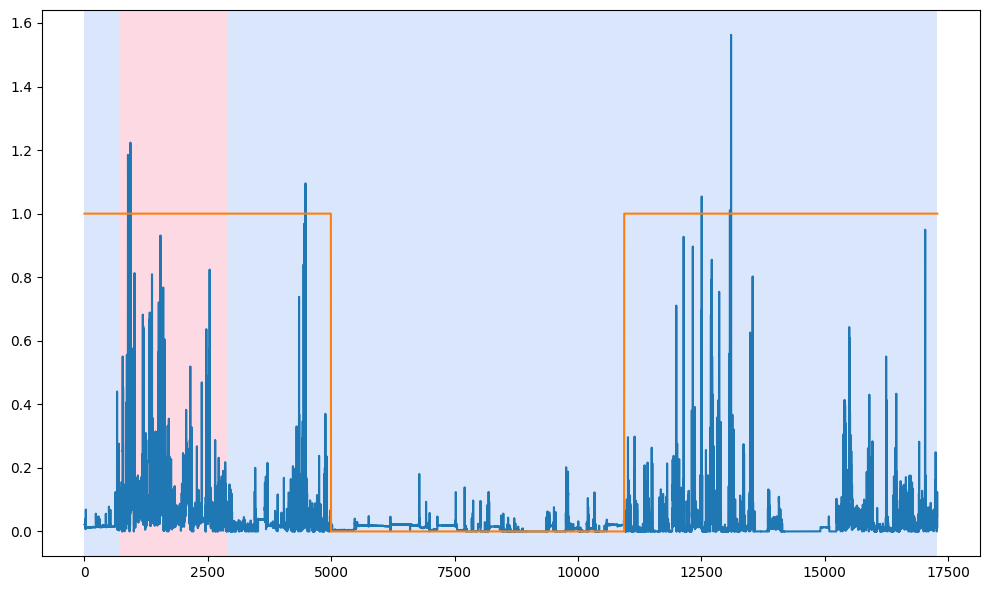

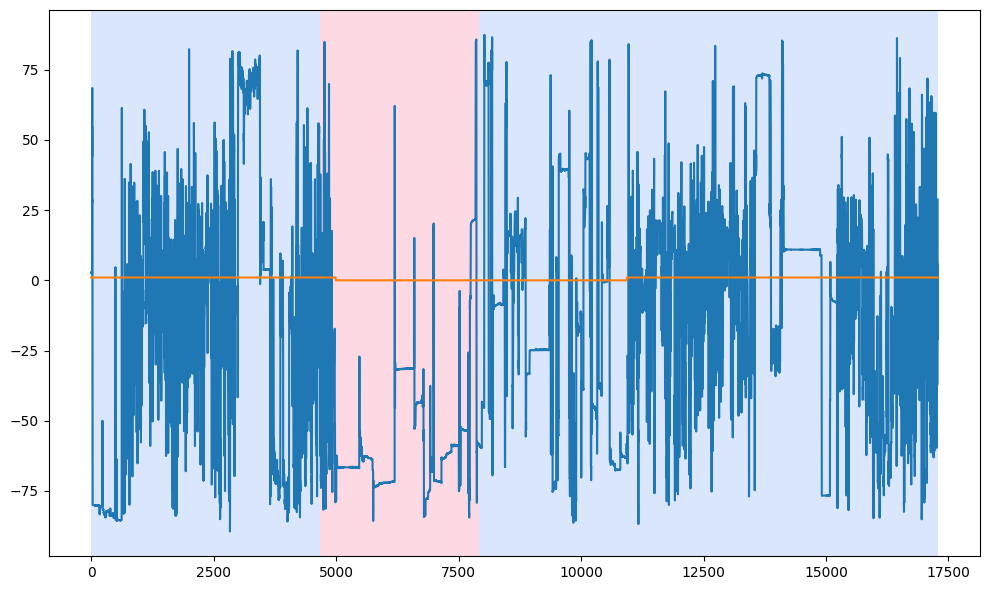

In [28]:
model = 'l1'
jumpDP = 360
algoDynamicProgrammingEnmo = rpt.Dynp(model=model, min_size=360, jump=jumpDP).fit(enmo)
algoDynamicProgrammingAnglez = rpt.Dynp(model=model, min_size=360, jump=jumpDP).fit(anglez)
my_bkpsEnmo = algoDynamicProgrammingEnmo.predict(n_bkps=2 * days_rpt)
my_bkpsAnglez = algoDynamicProgrammingAnglez.predict(n_bkps=2 * days_rpt)
rpt.show.display(enmo, my_bkpsEnmo, figsize=(10, 6))
plt.plot(awake)
rpt.show.display(anglez, my_bkpsAnglez, figsize=(10, 6))
plt.plot(awake)
plt.show()


Pelt
- Relies on a pruning rule in which indexes are discarded

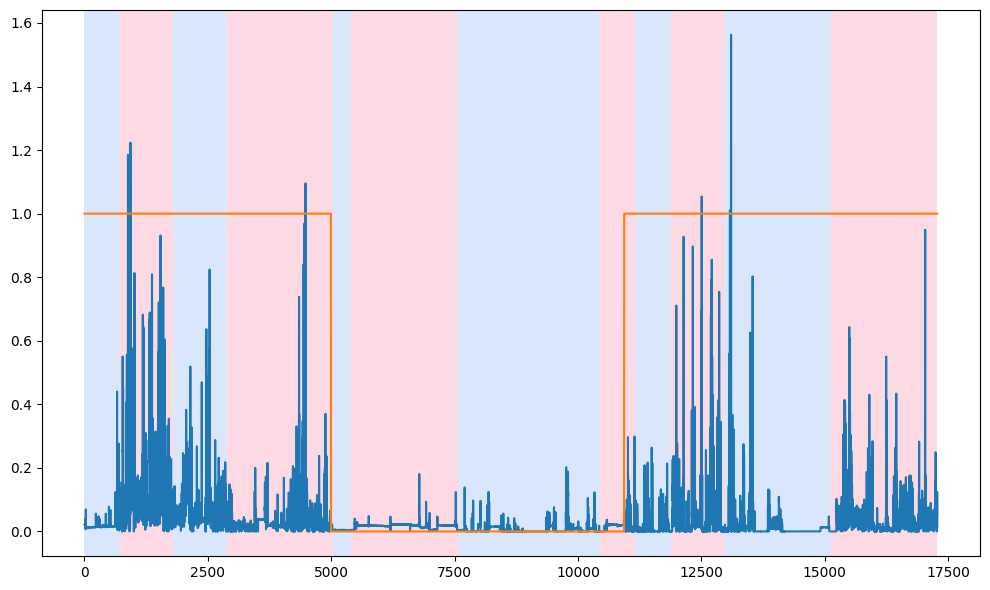

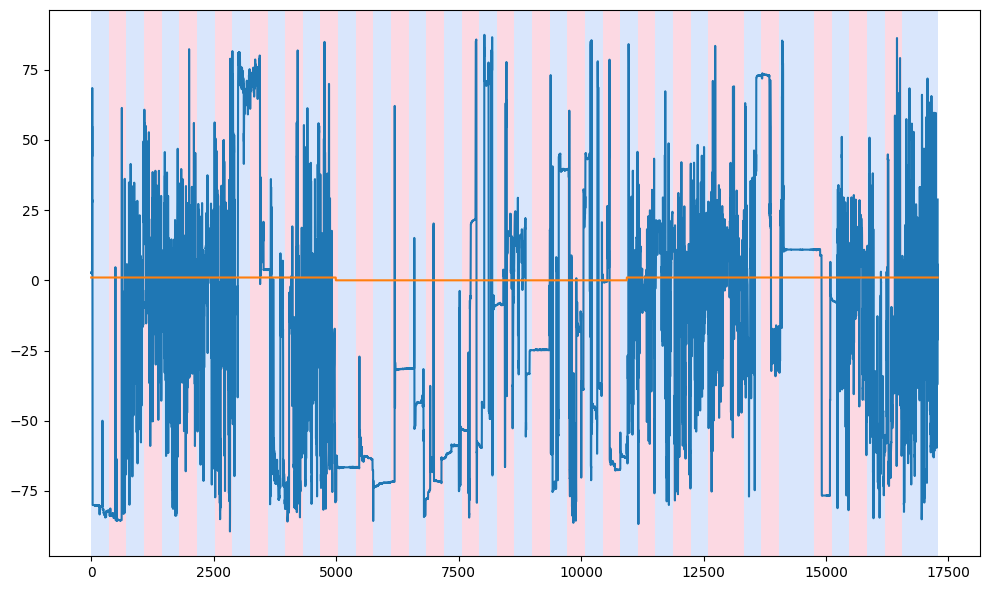

In [30]:
jumpPelt = 360
model = "l1"  # "l2", "rbf"
algoPeltEnmo = rpt.Pelt(model=model, min_size=360, jump=jumpPelt).fit(enmo)
algoPeltAnglez = rpt.Pelt(model=model, min_size=360, jump=jumpPelt).fit(anglez)
my_bkpsEnmo = algoPeltEnmo.predict(pen=2 * days_rpt)
my_bkpsAnglez = algoPeltAnglez.predict(pen=2 * days_rpt)
rpt.show.display(enmo, my_bkpsEnmo, figsize=(10, 6))
plt.plot(awake)
rpt.show.display(anglez, my_bkpsAnglez, figsize=(10, 6))
plt.plot(awake)
plt.show()

Binary Segmentation
- Used to perform fast signal segmentation
- Works by splitting signal at changepoint and then splitting subsequent signal to find next nested changepoint

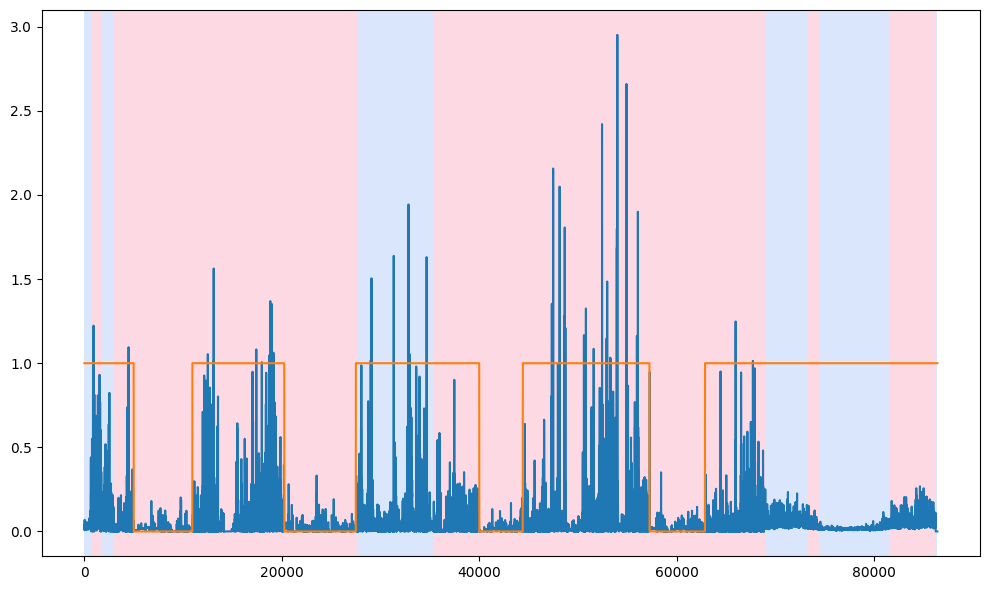

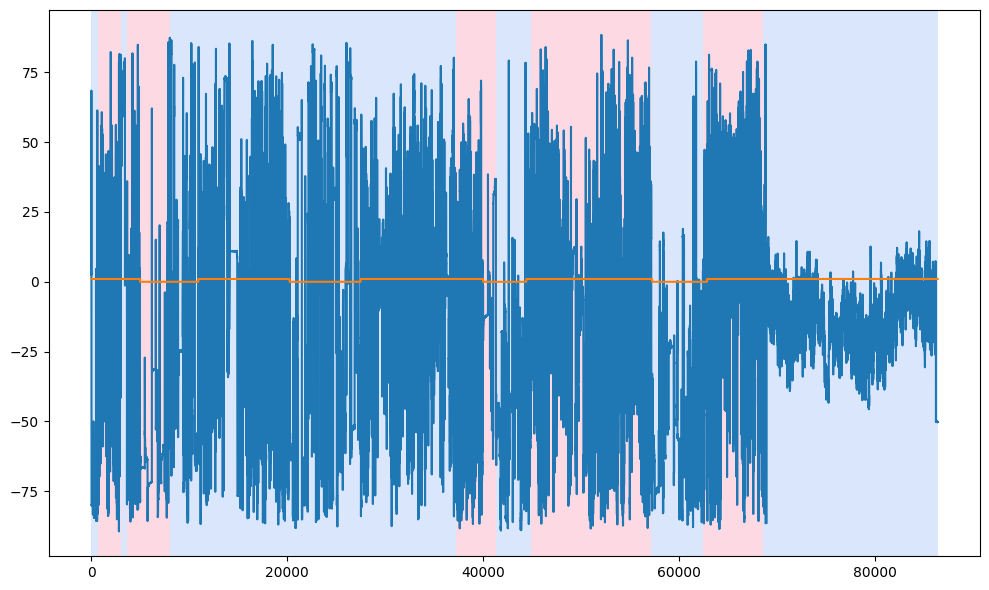

In [21]:
model = "l1"  # "l2", "rbf"
algoBinsegEnmo = rpt.Binseg(model=model).fit(enmo)
algoBinsegAnglez = rpt.Binseg(model=model).fit(anglez)
my_bkpsEnmoBinSeg = algoBinsegEnmo.predict(n_bkps=2 * days_rpt)
my_bkpsAnglezBinSeg = algoBinsegAnglez.predict(n_bkps=2 * days_rpt)
rpt.show.display(enmo, my_bkpsEnmo, figsize=(10, 6))
plt.plot(awake)
rpt.show.display(anglez, my_bkpsAnglez, figsize=(10, 6))
plt.plot(awake)
plt.show()


Bottom-up segmentation
- Used for fast change point detection, works by finding many changepoints and then deletes less significant ones

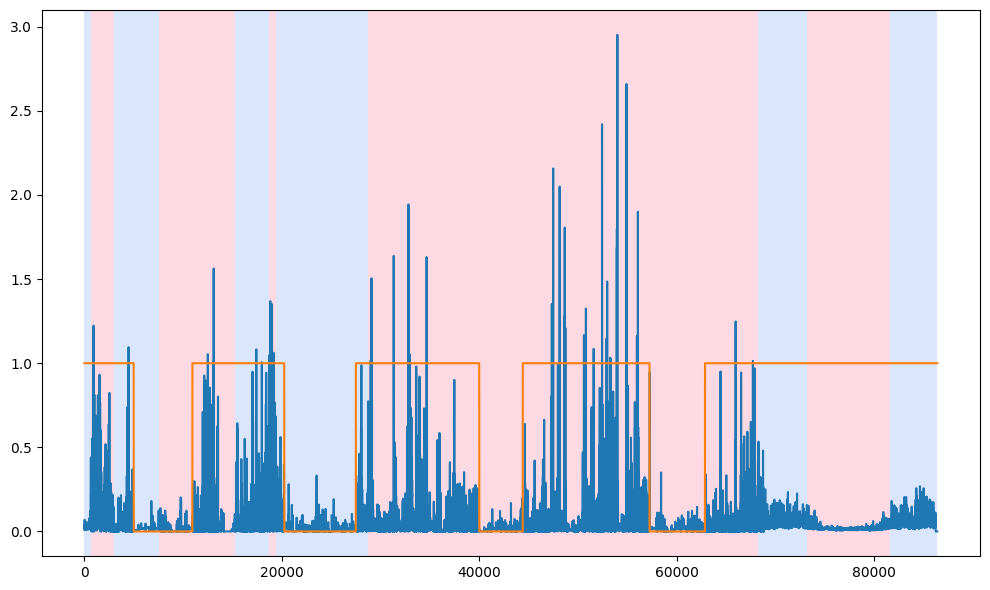

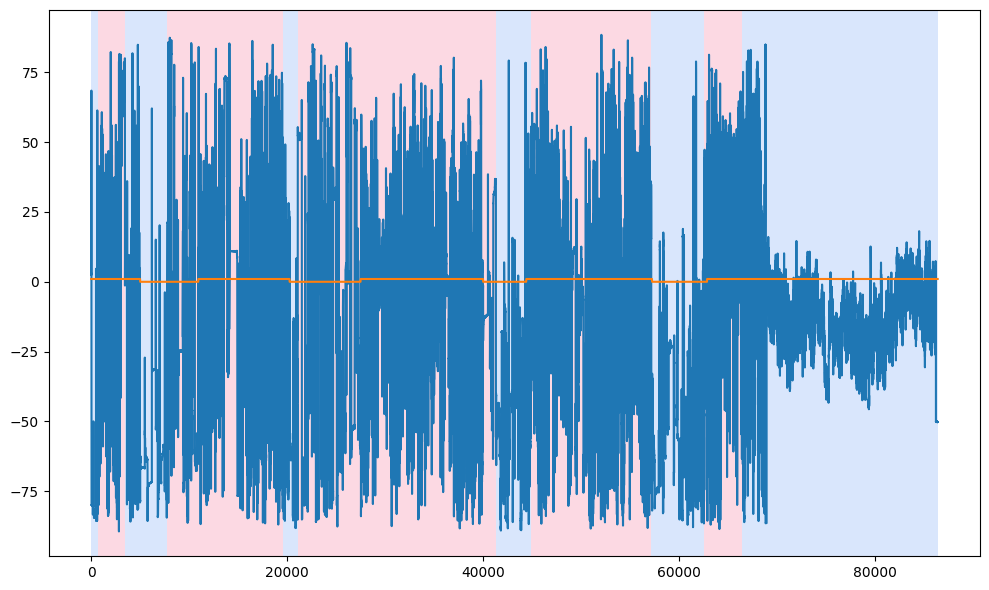

In [22]:
model = "l1"  # "l2", "rbf"
algoBottomUpEnmo = rpt.BottomUp(model=model).fit(enmo)
algoBottomUpAnglez = rpt.BottomUp(model=model).fit(anglez)
my_bkpsEnmoBottomUp = algoBottomUpEnmo.predict(n_bkps=2 * days_rpt)
my_bkpsAnglezBottomUp = algoBottomUpAnglez.predict(n_bkps=2 * days_rpt)
rpt.show.display(enmo, my_bkpsEnmoBottomUp, figsize=(10, 6))
plt.plot(awake)
rpt.show.display(anglez, my_bkpsAnglezBottomUp, figsize=(10, 6))
plt.plot(awake)
plt.show()

Window-based change point detection
- Uses two windows that slide along the data stream and compares the statistical properties within them to each other using a discrepance measure which is based on the cost function
- Does not work well for anglez or enmo, alignment happens once or twice but is mostly very far off

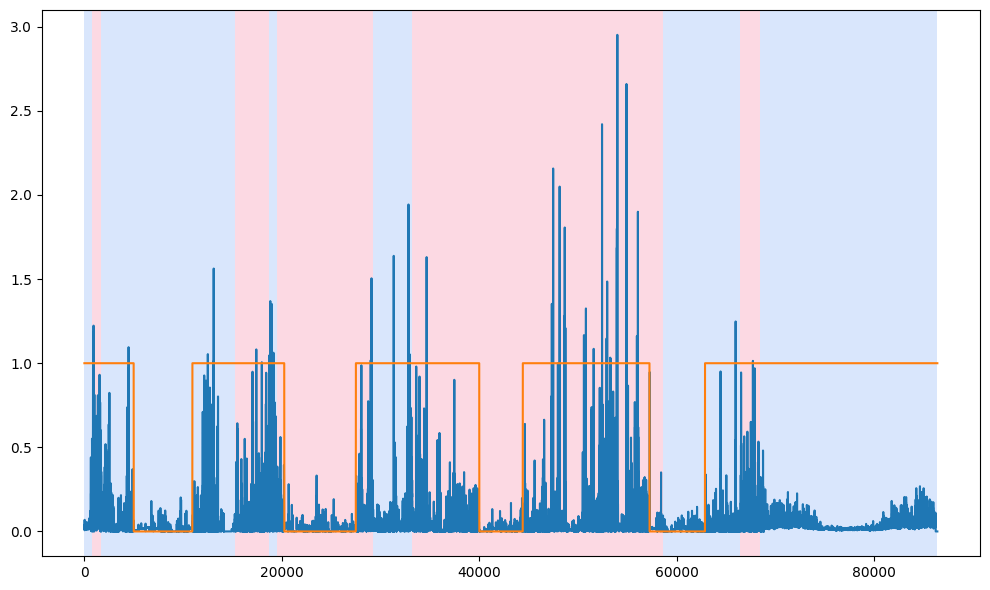

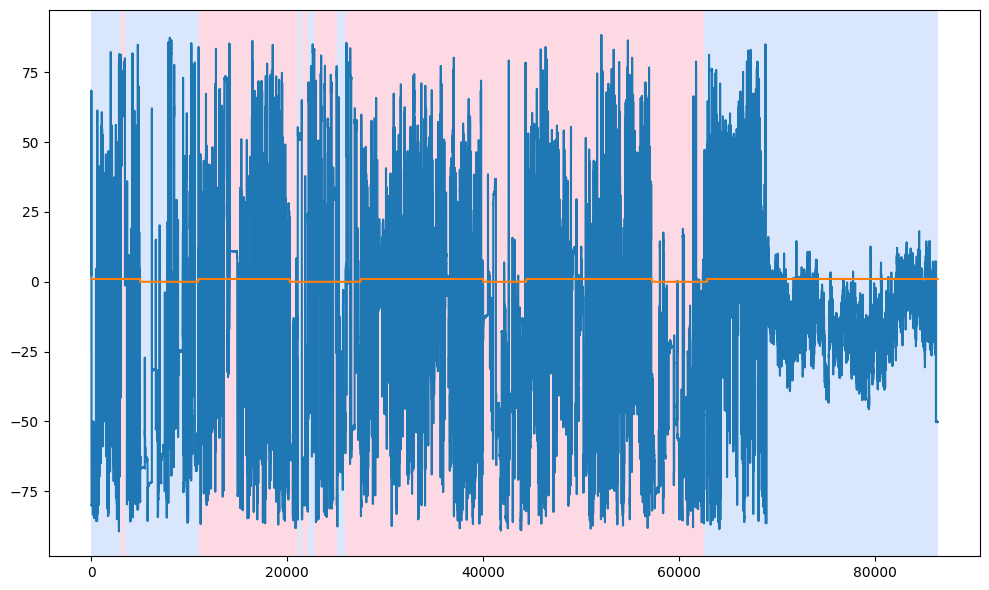

In [26]:
model = "l1"  # "l2", "rbf"
algoWindowEnmo = rpt.Window(width=720, model=model).fit(enmo)
algoWindowAnglez = rpt.Window(width=720, model=model).fit(anglez)
my_bkpsEnmoWindow = algoWindowEnmo.predict(n_bkps=2 * days_rpt)
my_bkpsAnglezWindow = algoWindowAnglez.predict(n_bkps=2 * days_rpt)
rpt.show.display(enmo, my_bkpsEnmoWindow, figsize=(10, 6))
plt.plot(awake)
rpt.show.display(anglez, my_bkpsAnglezWindow, figsize=(10, 6))
plt.plot(awake)
plt.show()

# Conclusion
Looking at the plots, the rupture package or more specifically changepoint detection does not work well for this dataset and problem. Although it can sometime detect an onset or awakening, most of the time it is far off and therefore not accurate enough for the competition. Using smaller jumps does increase accuracy but the running time increases quadratically and is not feasible for making a submission if it is to analyse multiple series and placed in an ensemble